In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
import functools
from scipy.stats import poisson

In [2]:
# Generate training data for sales probability regression
def generate_train_data(B=1000, T=100):

    def rank(a, p):
        return np.argsort(np.hstack((a, p)))[:,0]
    
    our_price = 10 + np.random.uniform(0, 10, (B, 1))
    competitor_prices = 10 + np.random.uniform(0, 10, (B, 5))
    our_rank = np.reshape(rank(our_price, competitor_prices), (B, 1))
    X = np.hstack((our_price, competitor_prices, our_rank))
    
    # Y = (our_rank == 0).astype(int).ravel()
#     Y = np.maximum(0, (3 - our_rank)).astype(int).ravel()
    Y = np.round(np.random.uniform(0, 1, our_rank.shape) * (1 - our_rank / 11)).ravel()
    
    return (X, Y)

X, Y = generate_train_data()

In [3]:
# Train sales probability model
def make_model(X, Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    def predict(x):
        return np.maximum(0, regr.predict(x))
        # return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


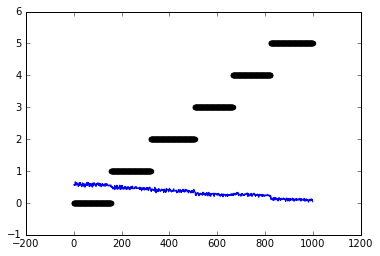

In [4]:
# Plot sales probability model
X_train, _ = generate_train_data(1000)
X_sort = np.sort(X_train.view('f8,f8,f8,f8,f8,f8,f8'), order=['f6'], axis=0).view(float)
plt.scatter(np.arange(0, X_sort.shape[0]), X_sort[:, 6], color='black')
plt.plot(np.arange(0, X_sort.shape[0]), sales_model(X_sort), color='blue', linewidth=1)

plt.show()

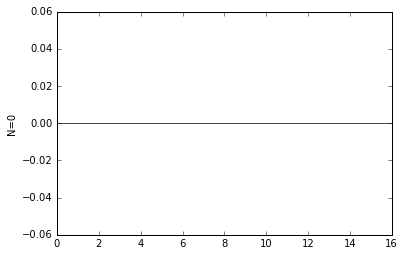

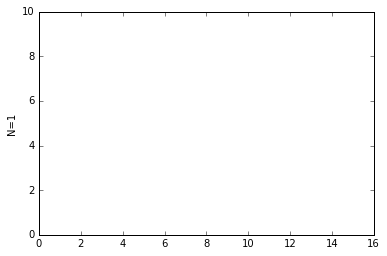

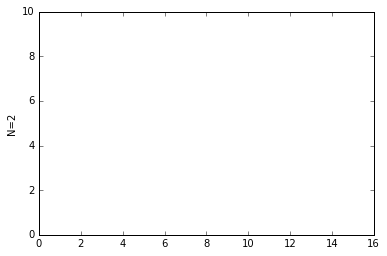

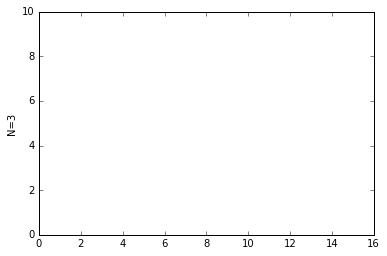

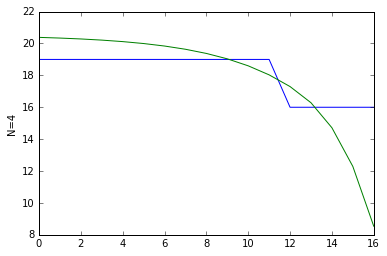

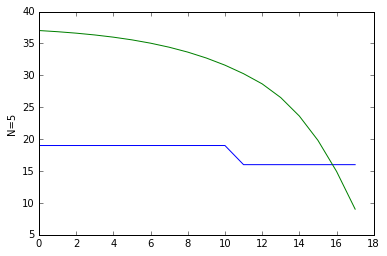

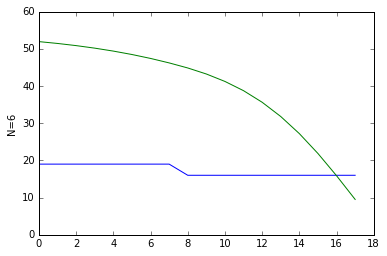

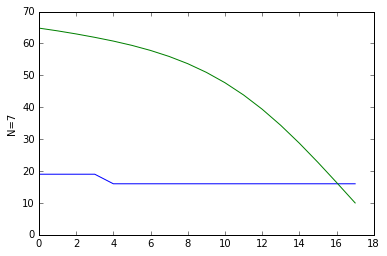

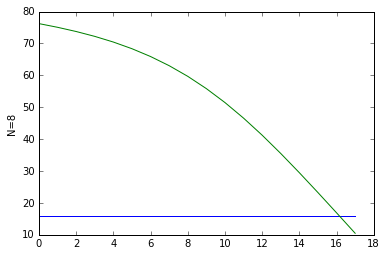

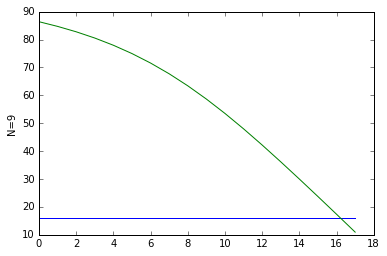

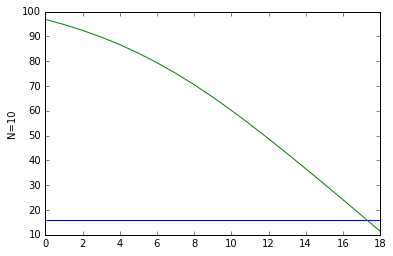

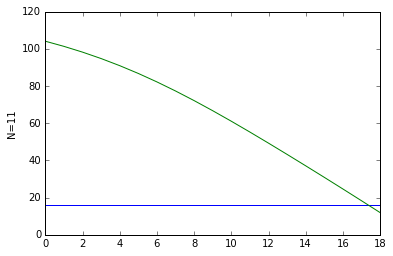

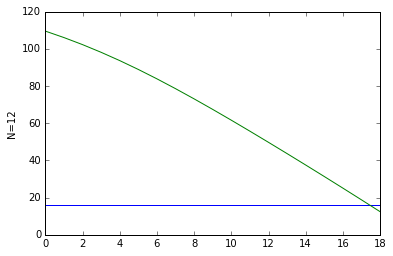

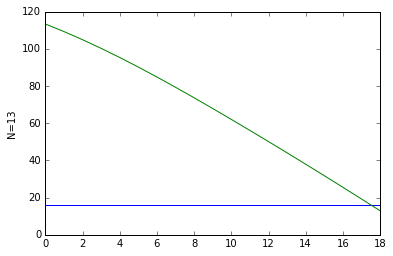

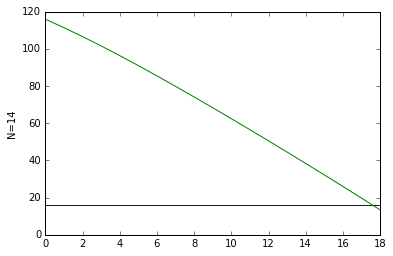

In [5]:
class OptimizeOptions():
    def __init__(self, sales_model, competitor_prices,
               T, N, L, Z, delta, price_range):
        self.sales_model = sales_model
        self.competitor_prices = competitor_prices
        self.T = T
        self.N = N
        self.L = L
        self.Z = Z
        self.delta = delta
        self.price_range = price_range

computed_values = {}
def optimize_run(t, N, options):
    def rank(a, p):
        _rank = p.shape[0]
        for i in range(p.shape[0]):
            if a < p[i]:
                _rank = _rank - 1
        return _rank

    @functools.lru_cache(maxsize=None)
    def sales_prob(price, options):
        x = np.hstack((price, options.competitor_prices, rank(price, options.competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]


    @functools.lru_cache(maxsize=None)
    def _V(price, t, n, options):
        p = sales_prob(price, options)
        _sum = 0
        for i in range(int(poisson.ppf(0.9999, p)) + 1):
            if i > n:
                return 0
            pi = poisson.pmf(i, p)
            today_profit = min(n, i) * price
            holding_costs = n * options.L
            _, V_future = V(t + 1, max(0, n - i), options)
            exp_future_profits = options.delta * V_future
            _sum += pi * (today_profit - holding_costs + exp_future_profits)
        return _sum
    
    @functools.lru_cache(maxsize=None)
    def V(t, n, options):
#         if (t,n) in computed_values:
#             return computed_values[t,n]
        if t >= options.T:
            computed_values[t,n] = (0, n * options.Z)
            return (0, n * options.Z)
        if n <= 0:
            computed_values[t,n] = (0, 0)
            return (0, 0)

        V_opt = -100000
        price_opt = -100000
        for i, price in enumerate(options.price_range):
            v = _V(price, t, n, options)
            if v > V_opt:
                V_opt = v
                price_opt = price
                
        computed_values[t,n] = (price_opt, V_opt)
        return (price_opt, V_opt)

    return V(t, N, options)
    

# Run Bellmann equation to calculate best price
def optimize_price(t, sales_model, competitor_prices,
               T=20, N=15, 
               price_range=np.arange(10, 20, 1), 
               L=0.01, delta=0.99, Z=0.5):

    return optimize_run(t, N, OptimizeOptions(sales_model, competitor_prices,
               T, N, L, Z, delta, price_range))

optimize_price(0, sales_model, 10 + np.random.uniform(0, 10, 5))



for i_n in range(15):
    datapoints = [ computed_values[i_t, i_n] for i_t in range(20) if(i_t, i_n) in computed_values ]
            
    plt.plot(datapoints)    
    plt.ylabel('N=' + str(i_n))
    plt.show()





In [6]:
def simulation(sales_model, competitor_prices, T=20, N=15):
    n = N
    
    def rank(a, p):
        order = np.argsort(np.hstack((a, p)))
        ranks = np.argsort(order)
        return ranks[0]
    
    def sales_prob(price):
        x = np.hstack((price, competitor_prices, rank(price, competitor_prices))).reshape(1, -1)
        return sales_model(x)[0]
   
    price_history = []
    accumulated_sales = []
    
    profit = 0

    for t in range(0, T):
        price, V = optimize_price(t, sales_model, competitor_prices, N=n, T=T)
        if t == 0:
            print(V)
        price_history.append(price)
        pi = sales_prob(price)
        sales = min(n, np.random.poisson(pi))
        n = n - sales
        profit += price * sales
        accumulated_sales.append(N - n)
        print(t, n, price, pi, competitor_prices, rank(price, competitor_prices))
        # competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        
    plt.plot(price_history)    
    plt.ylabel('Price Path')
    plt.show()
    
    plt.plot(accumulated_sales)    
    plt.ylabel('Accumulated Sales')
    plt.show()
    
    print(profit)
    return profit

# competitor_prices_simulation = 16 + np.random.uniform(0, 4, 5)
# simulation(sales_model, competitor_prices_simulation)

99.2309662656
0 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.9364

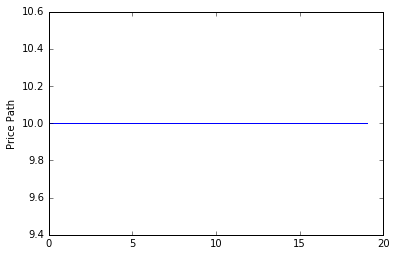

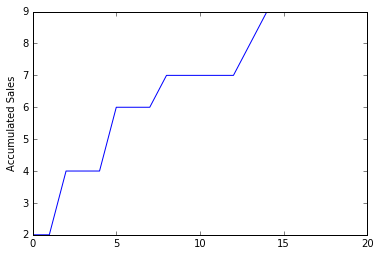

90
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732

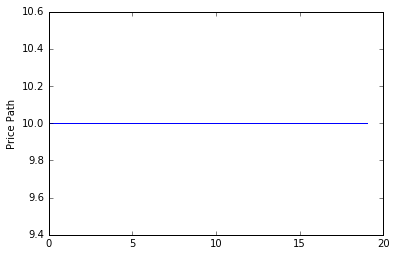

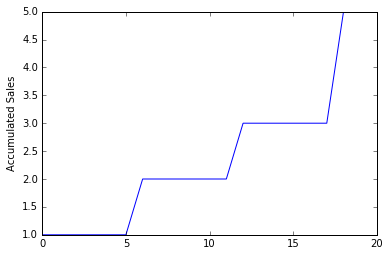

50
99.2309662656
0 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
3 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
4 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
5 6 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
6 6 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
7 6 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
8 2 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
9 1 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 1 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648

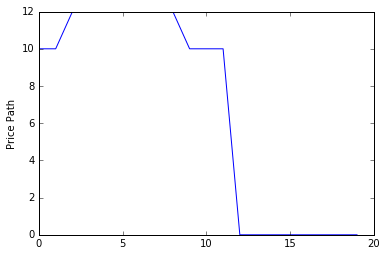

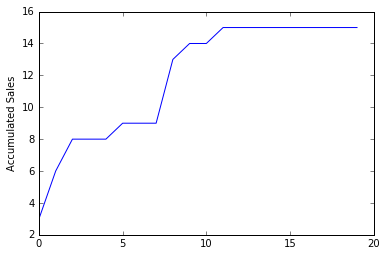

164
99.2309662656
0 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 6 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 5 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
10 4 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  1

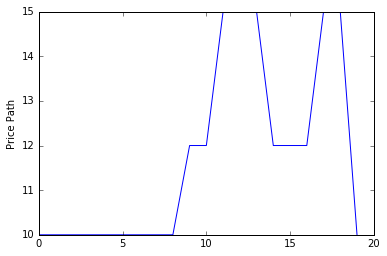

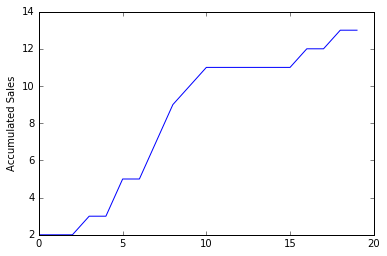

141
99.2309662656
0 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 12 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

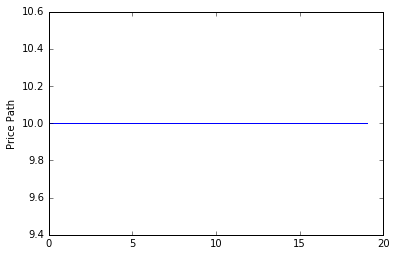

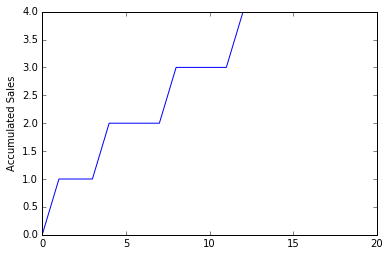

40
99.2309662656
0 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732

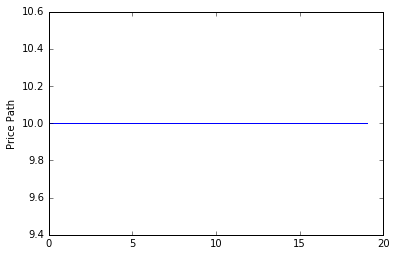

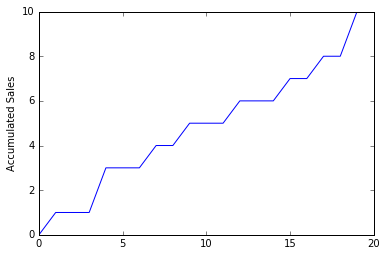

100
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10

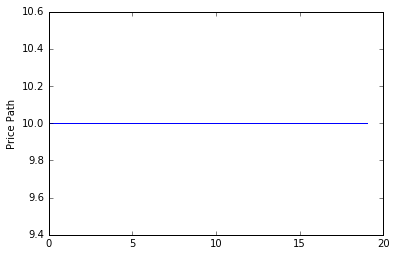

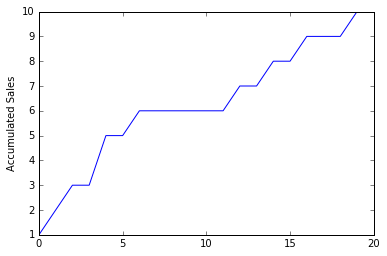

100
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  1

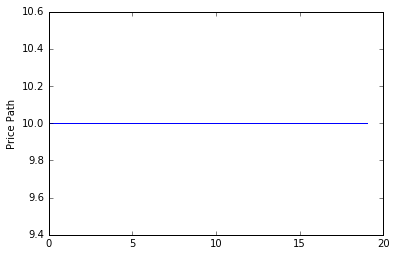

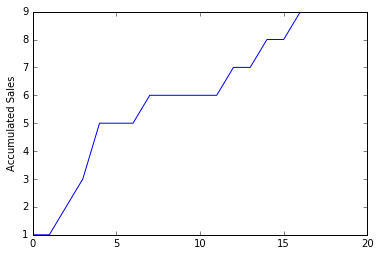

90
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 7 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
10 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.

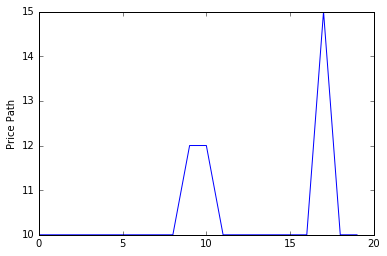

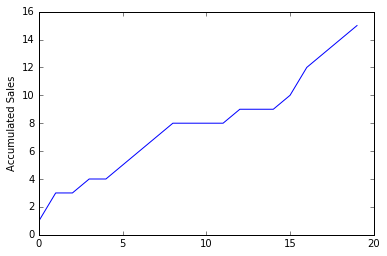

155
99.2309662656
0 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 12 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

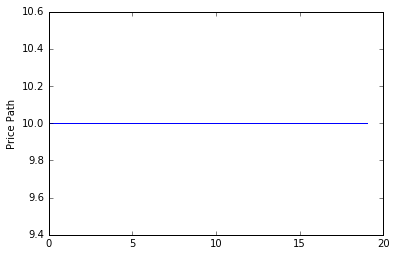

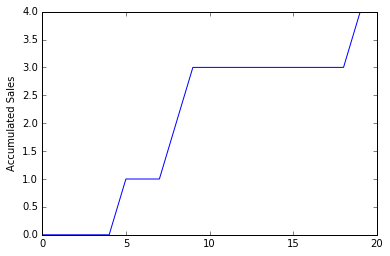

40
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 7 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
8 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
9 7 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
10 6 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.9

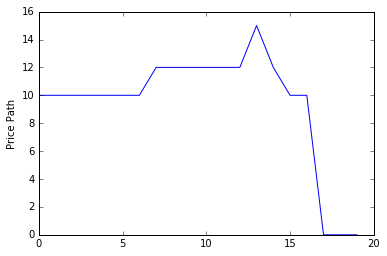

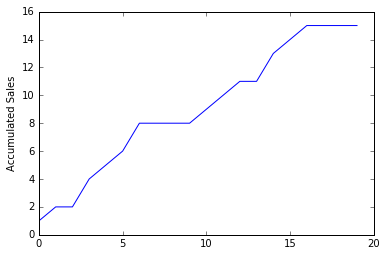

160
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 10 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

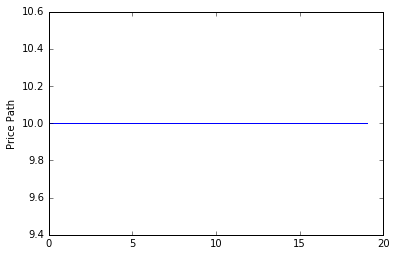

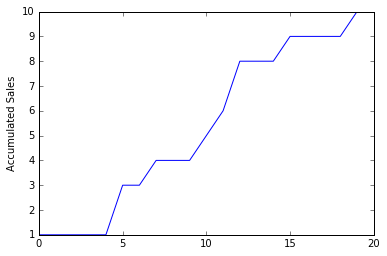

100
99.2309662656
0 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 10 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

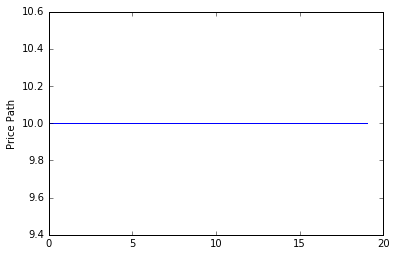

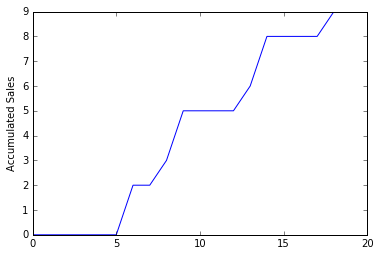

90
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 7 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 6 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
6 6 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
7 4 12 0.405896698004 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 2
8 4 19 0.12240050854 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 5
9 4 15 0.227327874743 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 4
10 4 15 0.227327874743 [ 13.10828747  12.51482016  15.01733732  10.936

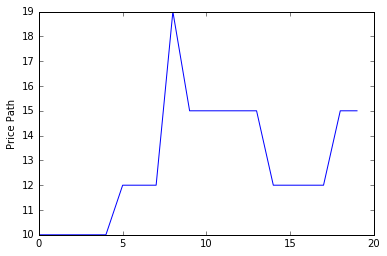

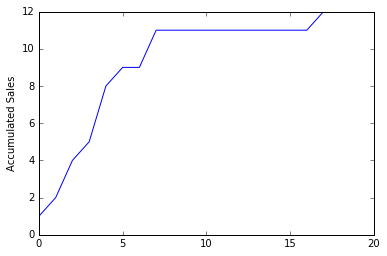

128
99.2309662656
0 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 12 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

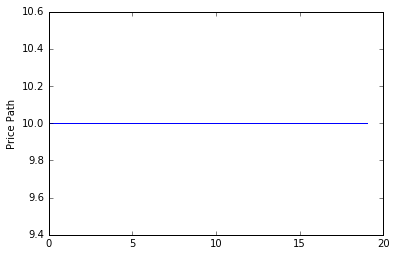

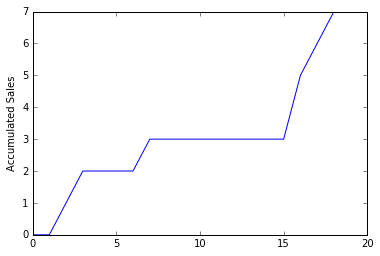

70
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 7 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10

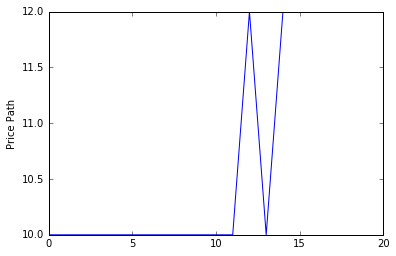

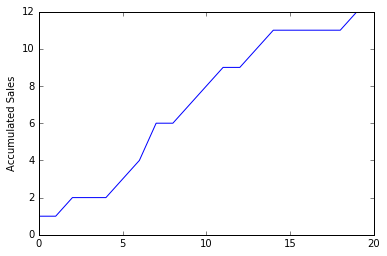

124
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 10 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

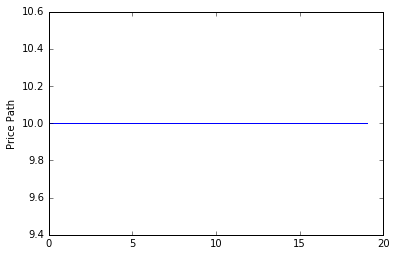

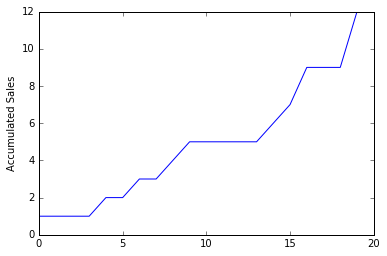

120
99.2309662656
0 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 15 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 8 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10

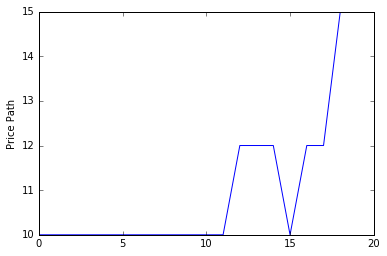

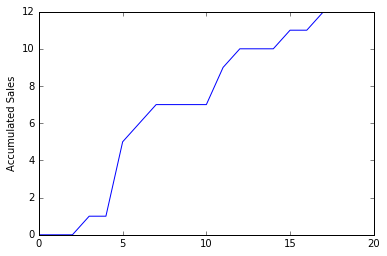

124
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 11 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 10 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 9 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 7 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  1

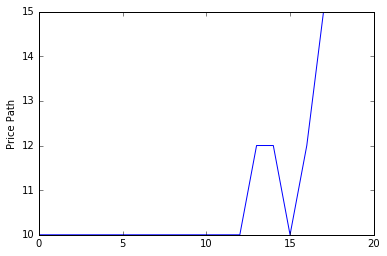

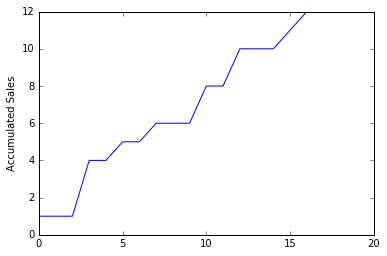

122
99.2309662656
0 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
1 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
2 14 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
3 13 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
4 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
5 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
6 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
7 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
8 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
9 12 10 0.578208339435 [ 13.10828747  12.51482016  15.01733732  10.93648708  10.64772364] 0
10 11 10 0.578208339435 [ 13.10828747  12.51482016  15.0173373

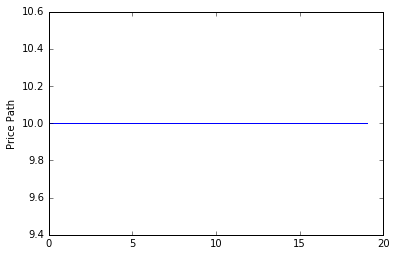

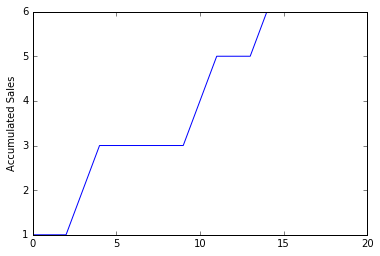

60


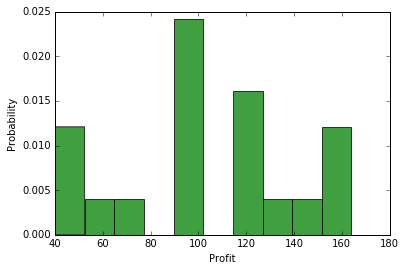

In [7]:
competitor_prices = 10 + np.random.uniform(0, 10, 5)
profits = list(map(lambda i: simulation(sales_model, competitor_prices), range(0, 20)))
    
n, bins, patches = plt.hist(profits, 10, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Profit')
plt.ylabel('Probability')
plt.show()